# kaggle chest_x-ray Dataset

### train, test, val 경로 설정 및 파일 갯수 확인

In [1]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers, models, optimizers
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
train_dir = './train'
test_dir = './test'
val_dir = './val'

train_normal_dir = './train/NORMAL'
validation_normal_dir = './test/NORMAL'
test_normal_dir = './val/NORMAL'

train_pneumonia_dir = './train/PNEUMONIA'
validation_pneumonia_dir = './test/PNEUMONIA'
test_pneumonia_dir = './val/PNEUMONIA'

In [3]:
print("train normal images count : ", len(os.listdir(train_normal_dir)))
print("validation normal images count : ", len(os.listdir(validation_normal_dir)))
print("test normal images count : ", len(os.listdir(test_normal_dir)))
print("\n")
print("train pneumonia images count : ", len(os.listdir(train_pneumonia_dir)))
print("validation pneumonia images count : ", len(os.listdir(validation_pneumonia_dir)))
print("test pneumonia images count : ", len(os.listdir(test_pneumonia_dir)))

train normal images count :  1341
validation normal images count :  234
test normal images count :  8


train pneumonia images count :  3875
validation pneumonia images count :  390
test pneumonia images count :  8


### 데이터 전처리
- 1. read image files
- 2. decode JPEG contents to RGB pixel values
- 3. convert float type tensor
- 4. regulation pixel 0-255 to 0-1
- all above process can be completed by using keras.preprocessing.image especially ImageDataGenerator Class

In [4]:
# train_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(150, 150),
#     batch_size=20,
#     class_mode='binary'
# )

# validation_generator = test_datagen.flow_from_directory(
#     val_dir,
#     target_size=(150, 150),
#     batch_size=20,
#     class_mode='binary'
# )


### 데이터 증식(Data augmentation)

findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans.


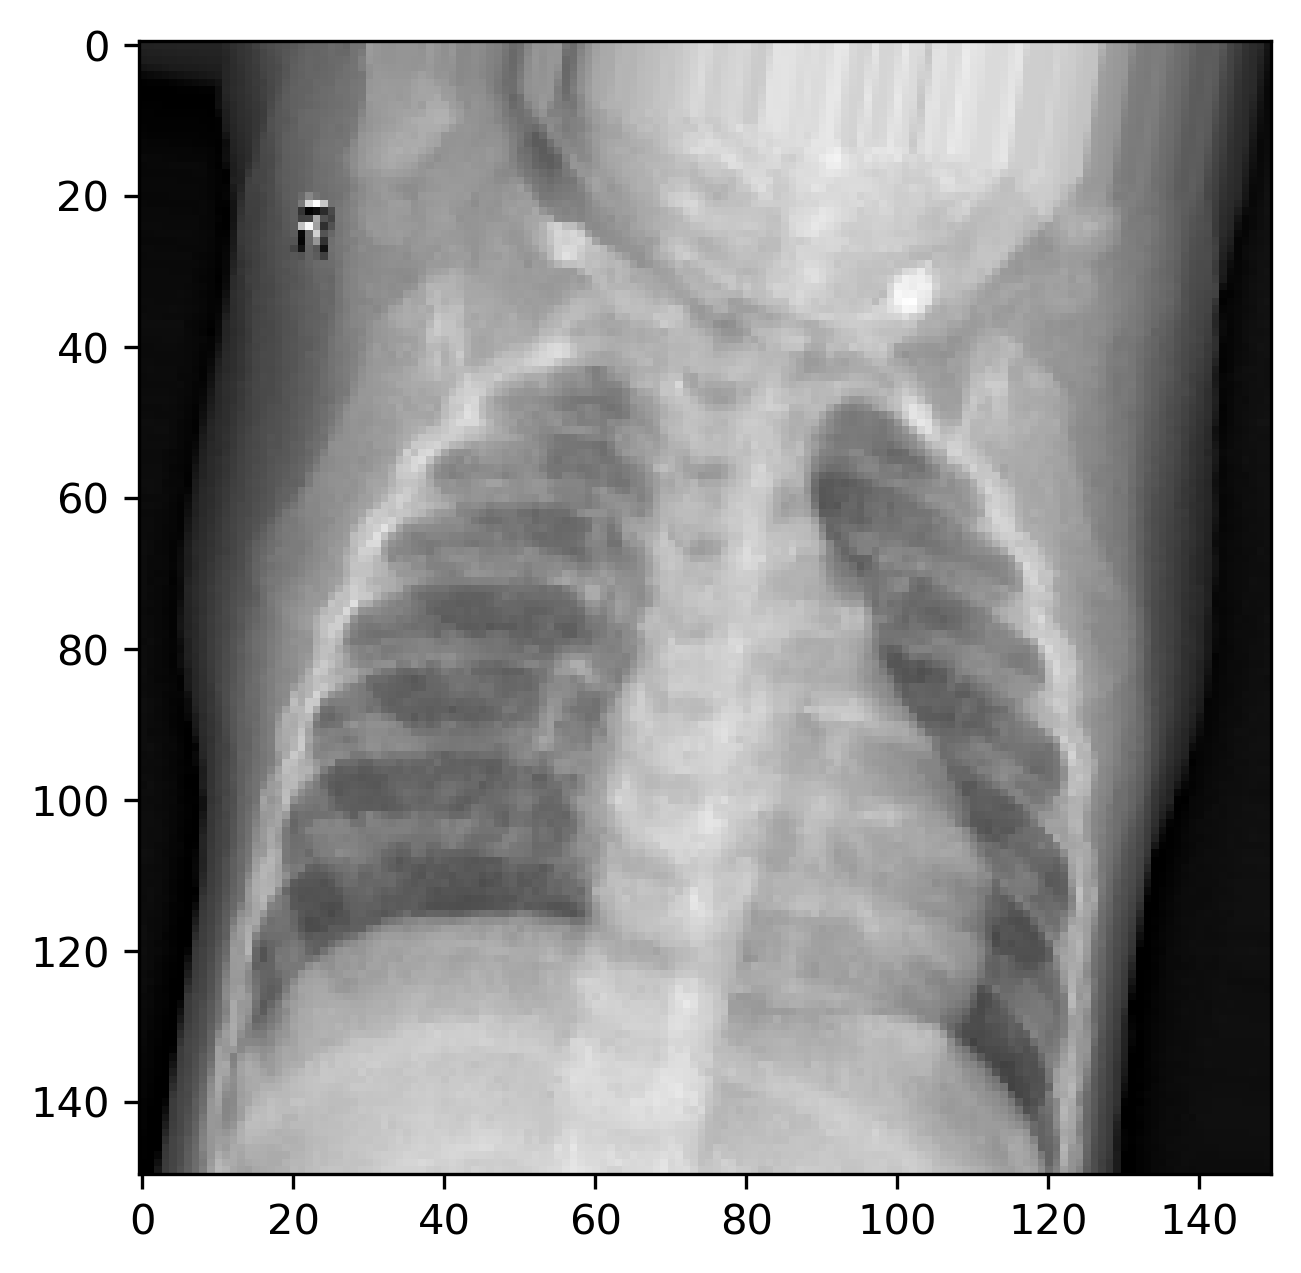

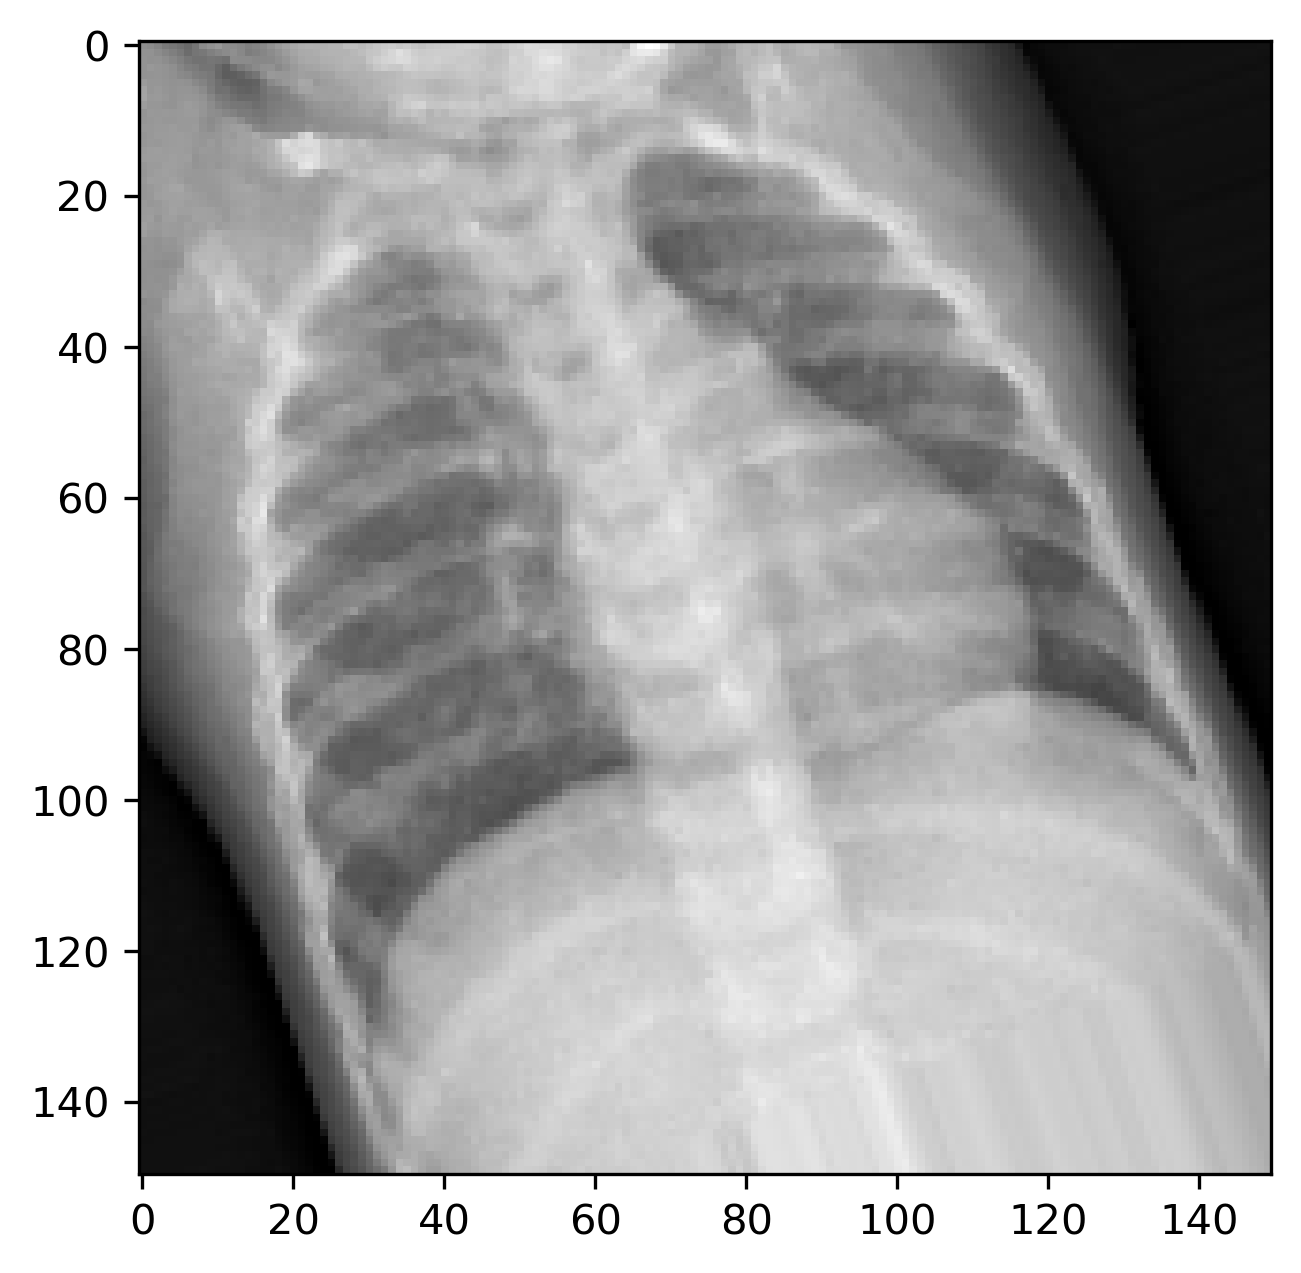

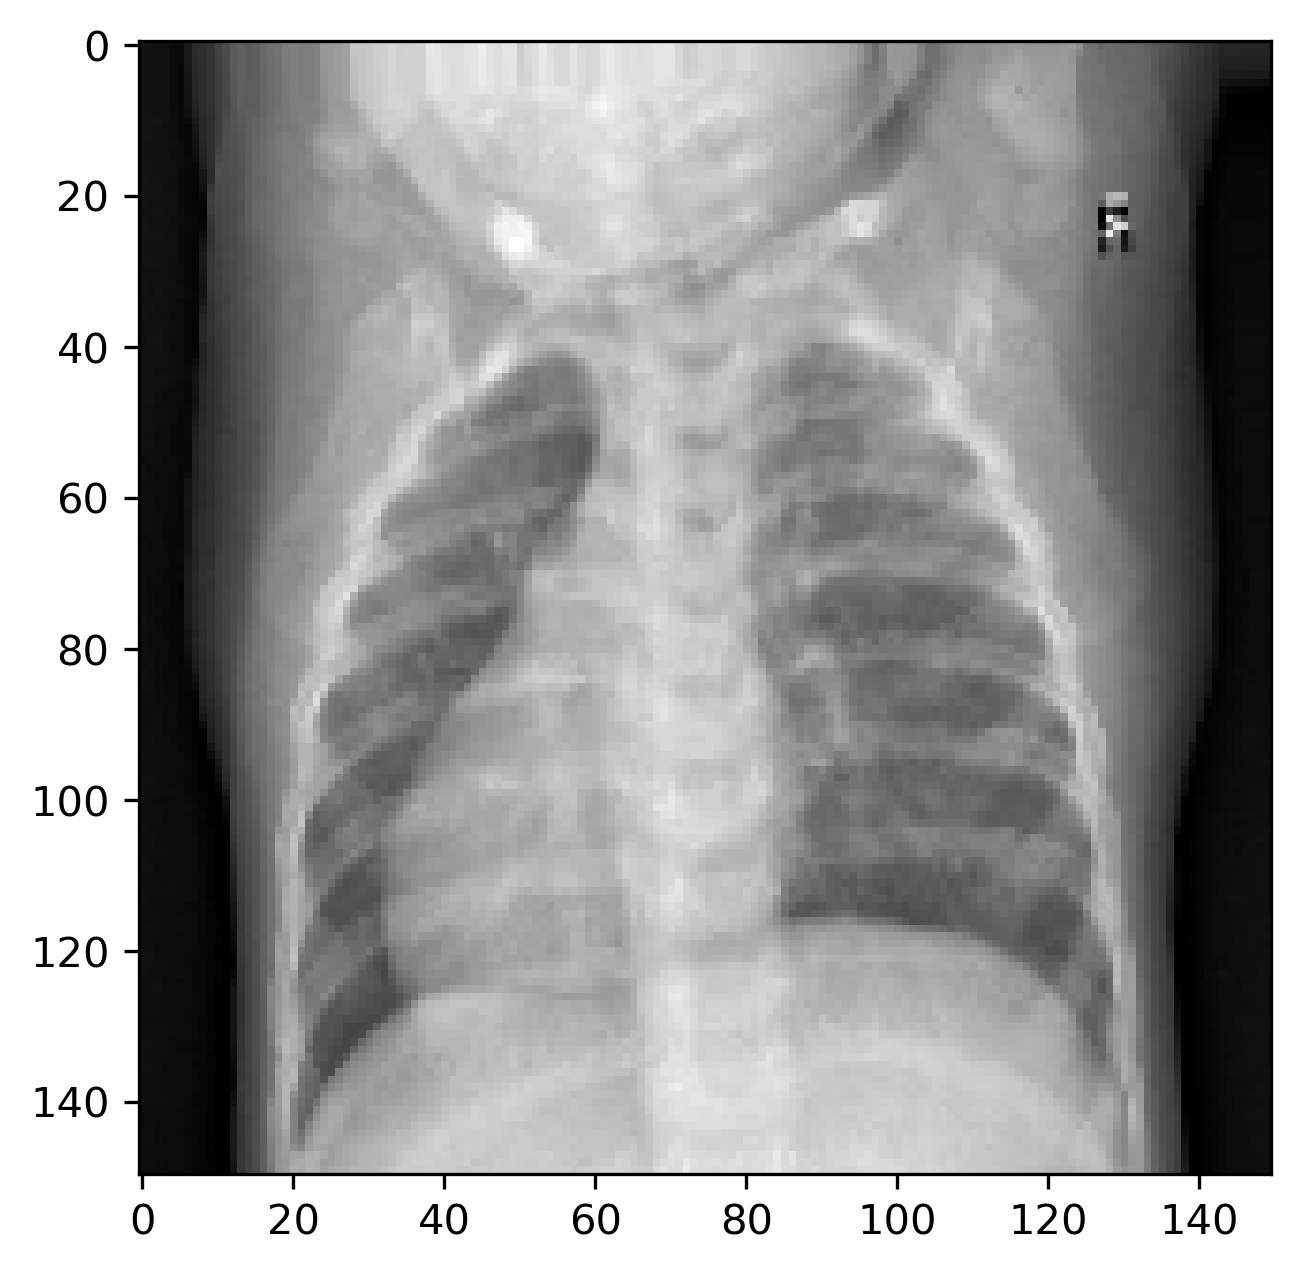

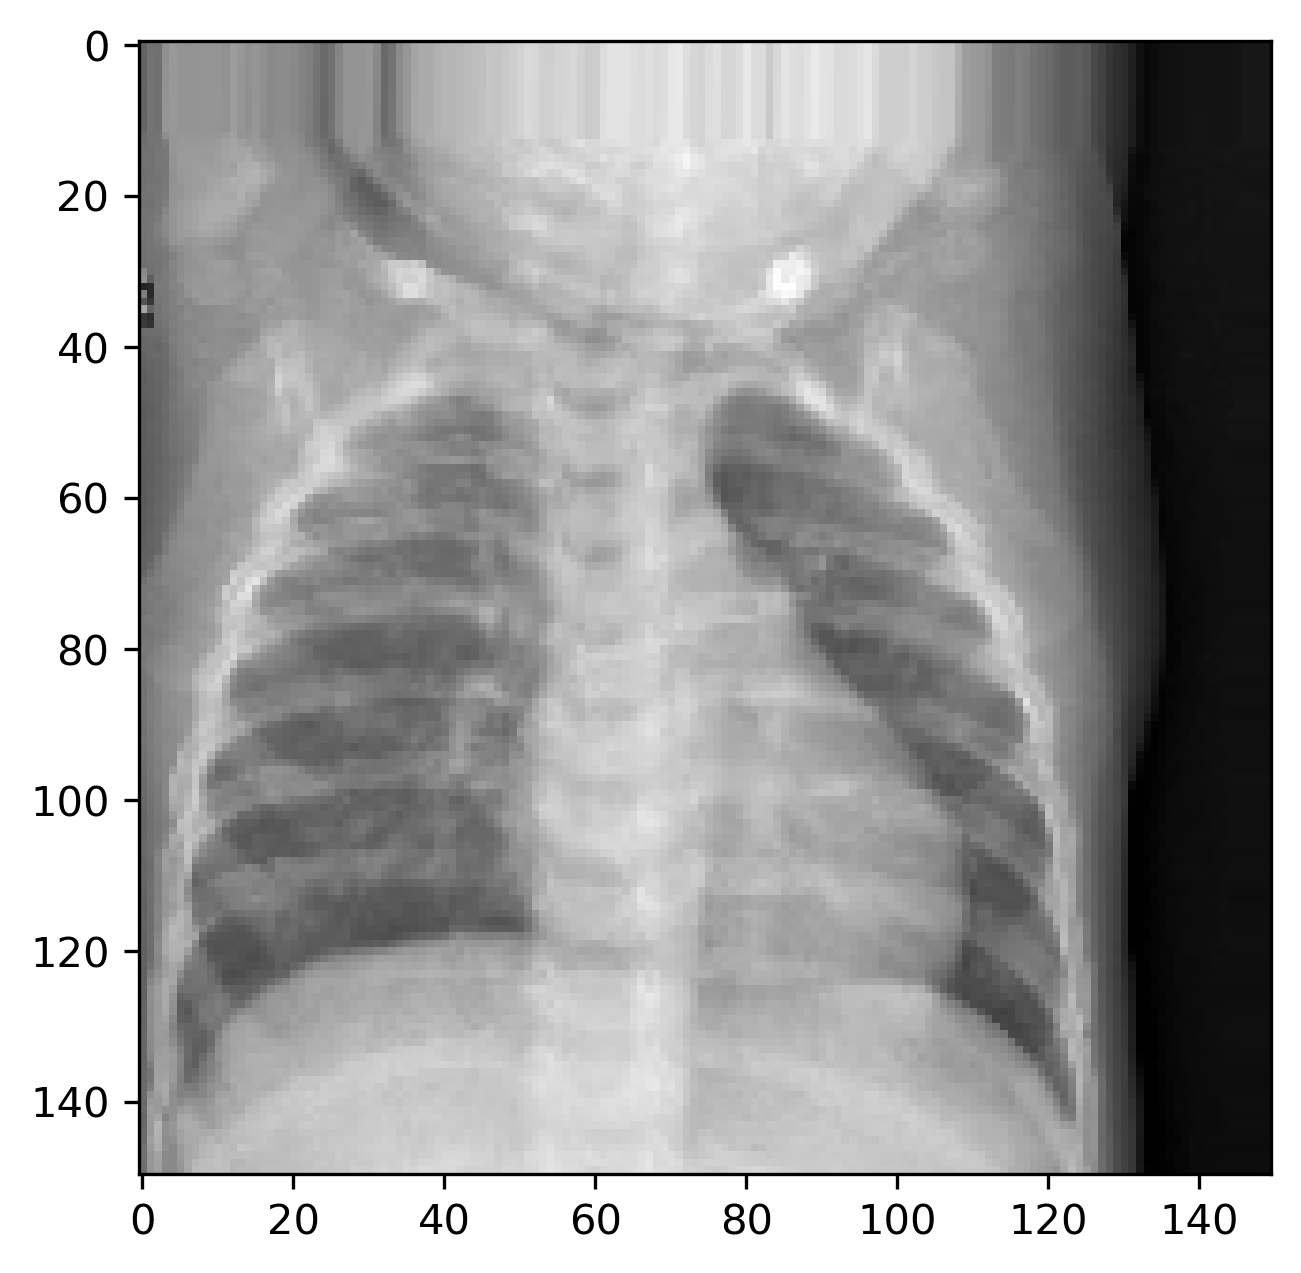

In [5]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

fnames = sorted([os.path.join(train_normal_dir, fname) for fname in os.listdir(train_normal_dir)])
img_path = fnames[3]
img = image.load_img(img_path, target_size=(150, 150))
x=image.img_to_array(img)
x = x.reshape((1,)+x.shape)

i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i%4 == 0:
        break
plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255) # 검증데이터는 증식되면안됨!

train_generator= train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

validation_generator= test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### 네트워크 구성

In [8]:
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss = 'binary_crossentropy',
             metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                             validation_steps=50)

model.save('chest_x_ray.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 93s 927ms/step - loss: 0.5707 - acc: 0.7425 - val_loss: 0.7388 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 89s 894ms/step - loss: 0.5055 - acc: 0.7684 - val_loss: 0.6317 - val_acc: 0.6250
Epoch 3/100
100/100 [==============================] - 88s 879ms/step - loss: 0.4527 - acc: 0.7966 - val_loss: 0.8529 - val_acc: 0.6250
Epoch 4/100
100/100 [==============================] - 89s 893ms/step - loss: 0.4287 - acc: 0.8025 - val_loss: 0.5654 - val_acc: 0.7500
Epoch 5/100
100/100 [==============================] - 91s 907ms/step - loss: 0.3836 - acc: 0.8203 - val_loss: 0.8442 - val_acc: 0.5625
Epoch 6/100
100/100 [==============================] - 90s 900ms/step - loss: 0.3664 - acc: 0.8419 - val_loss: 1.3938 - val_acc: 0.5000
Epoch 7/100
100/100 [==============================] - 88s 882ms/step - loss: 0.3412 - acc: 0.8525 - val_loss: 1.0294 - val_acc: 0.5000


KeyboardInterrupt: 

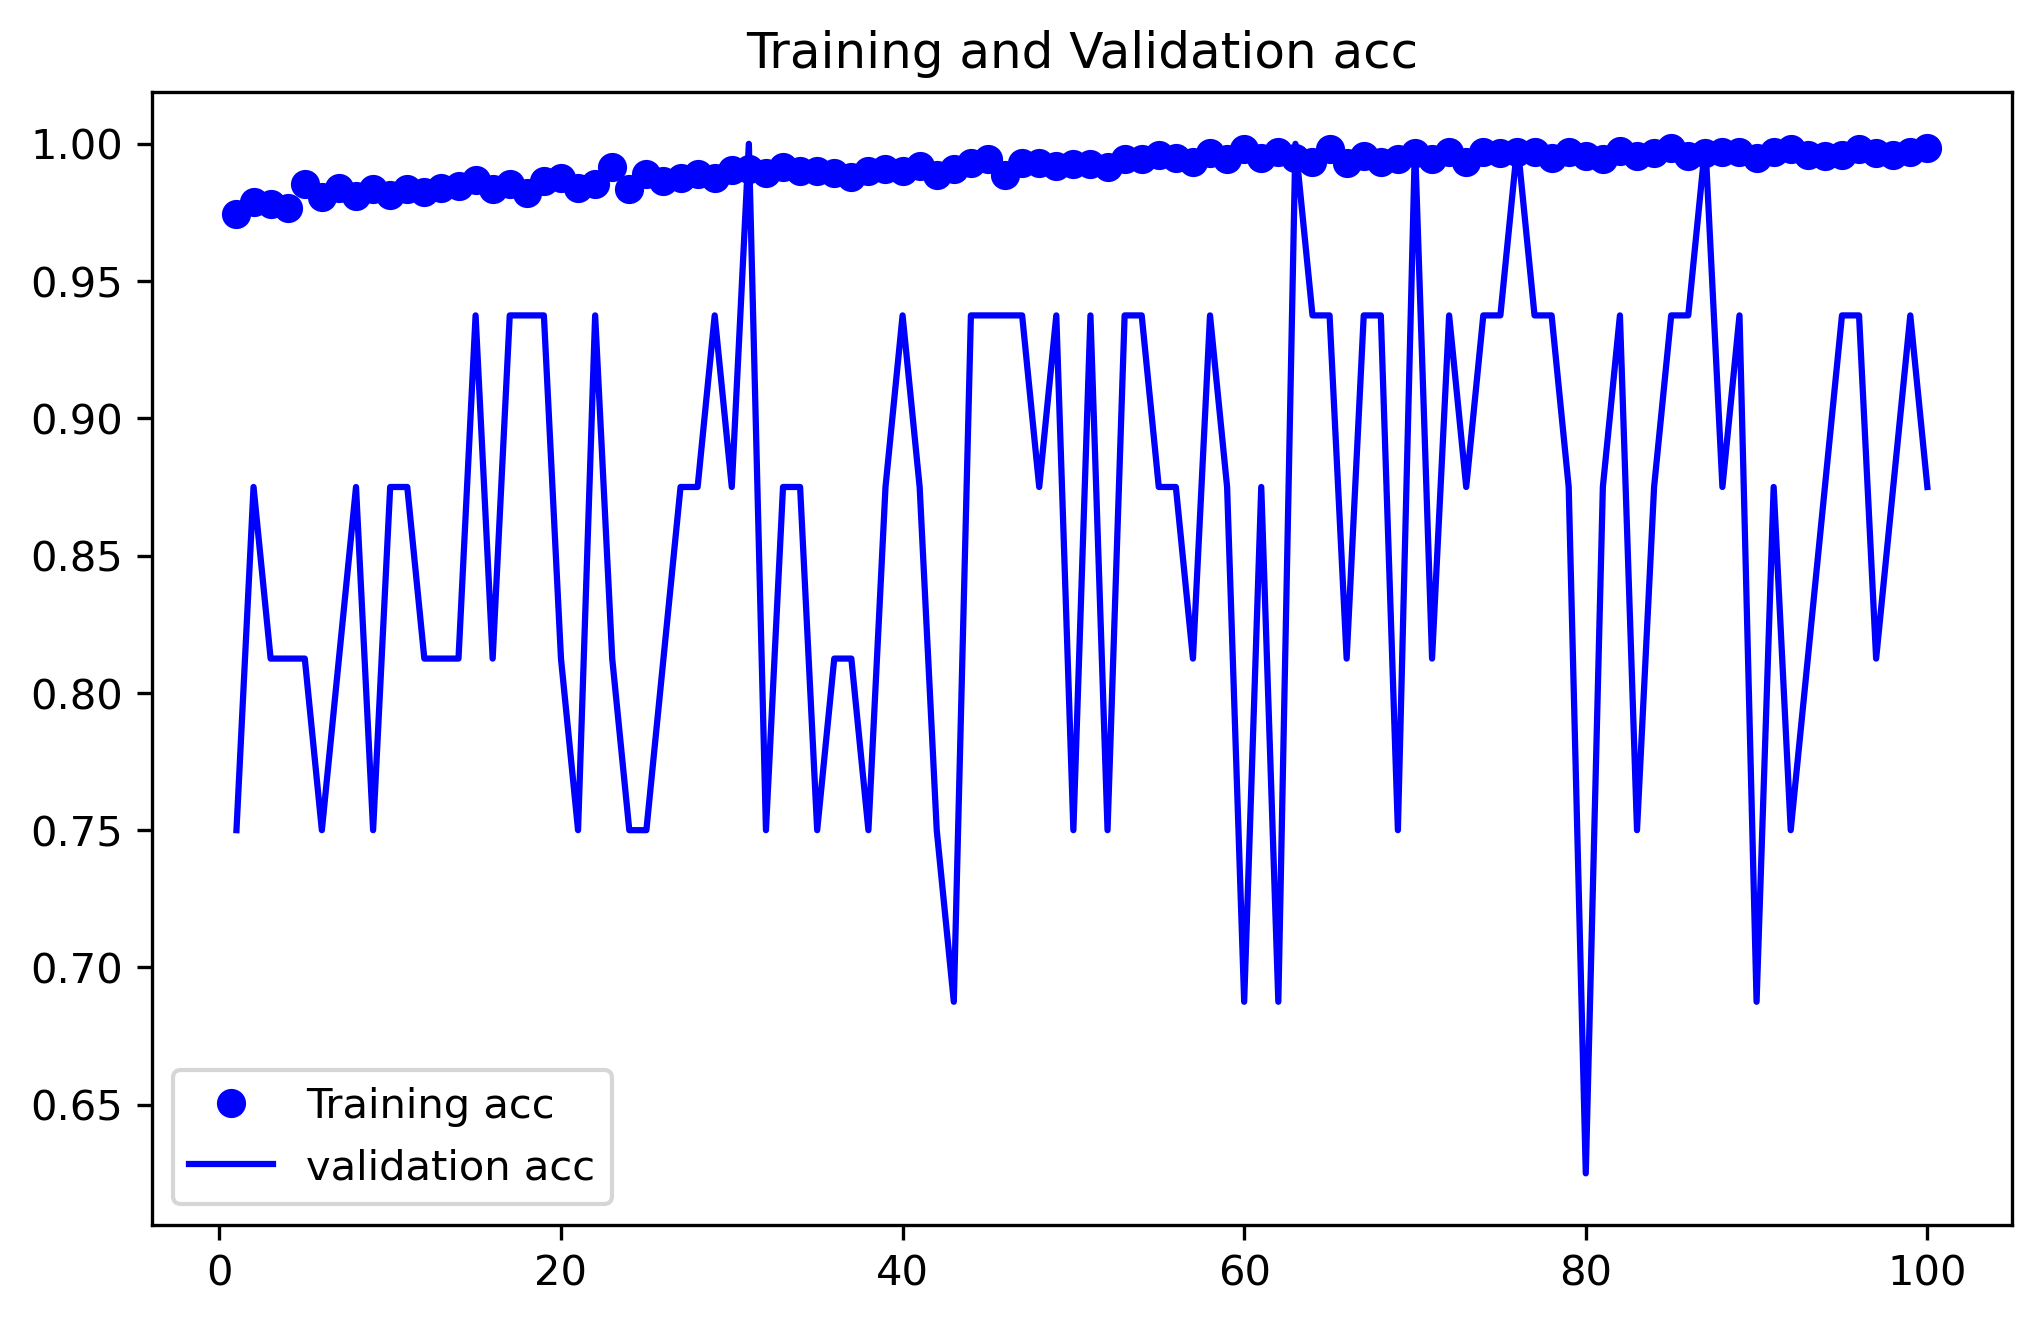

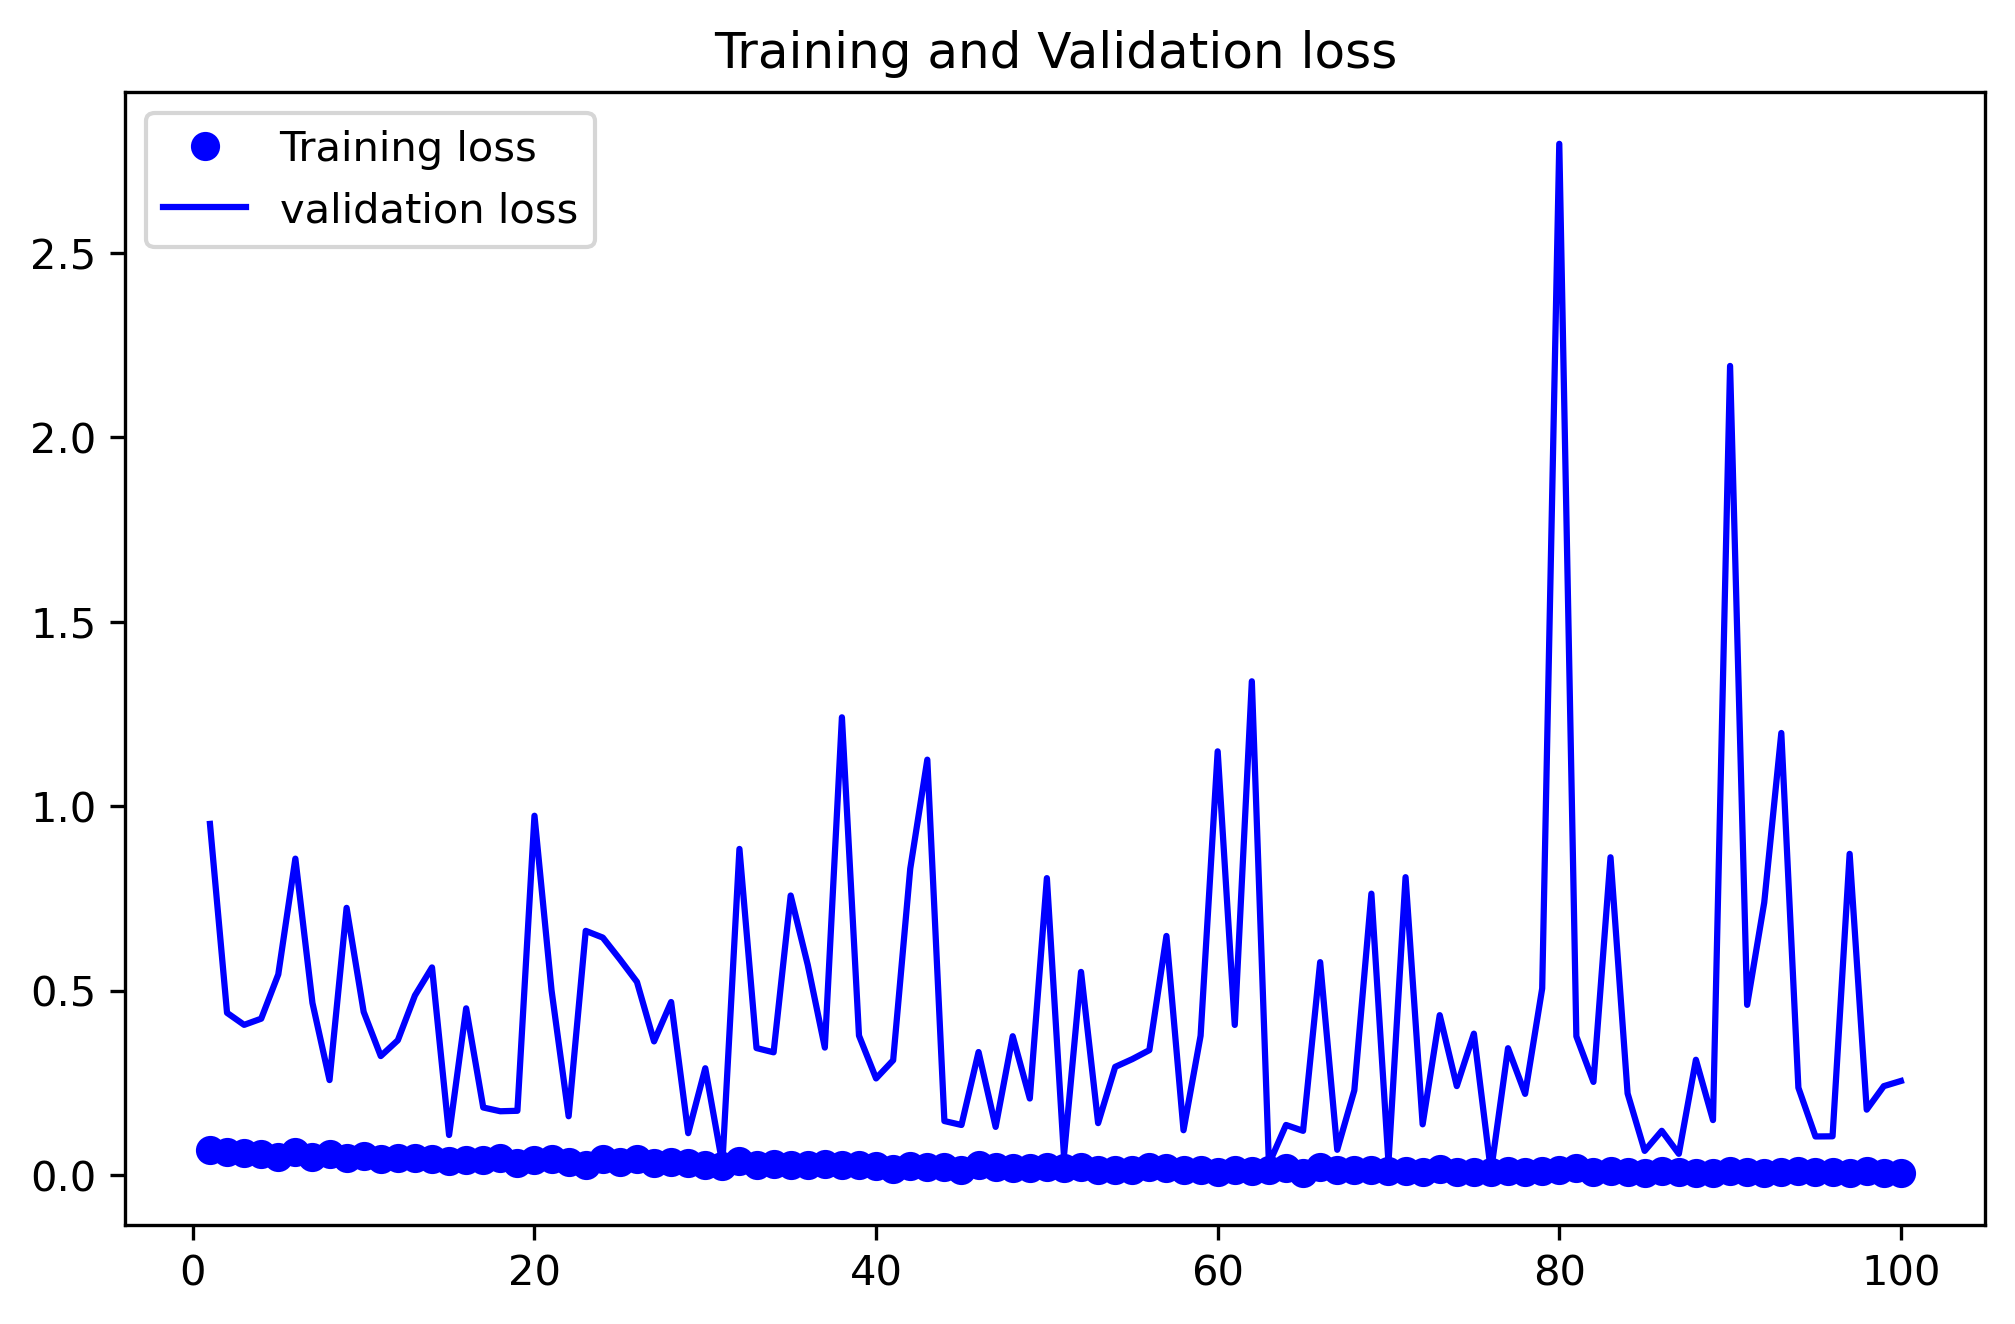

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.legend()

plt.figure()

plt.ylim
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [22]:
# 테스트
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc : ', test_acc)

Found 624 images belonging to 2 classes.
test acc :  0.760162603806674


# Test Result Log
- 데이터 전처리 추가 : 0.7551
- 데이터 증식 추가 : 0.760162603806674

## 네트워크 구성하기

### 강아지 vs 고양이 분류를 위한 소규모 컨브넷 만들기

In [21]:
from keras import layers, models, optimizers

In [24]:
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss = 'binary_crossentropy',
              metrics=['acc'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)       147584    
__________

### 데이터 전처리
- 1. read image files
- 2. decode JPEG contents to RGB pixel values
- 3. convert float type tensor
- 4. regulation pixel 0-255 to 0-1
- all above process can be completed by using keras.preprocessing.image especially ImageDataGenerator Class

### ImageGenerator를 사용하여 디렉터리에서 이미지 읽기

In [26]:
from keras.preprocessing.image import ImageDataGenerator

In [27]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 배치 제너레이터를 사용해 모델 훈련하기

In [33]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 49s 492ms/step - loss: 0.6902 - acc: 0.5390 - val_loss: 0.6775 - val_acc: 0.6280
Epoch 2/30
100/100 [==============================] - 46s 461ms/step - loss: 0.6642 - acc: 0.6020 - val_loss: 0.6604 - val_acc: 0.5840
Epoch 3/30
100/100 [==============================] - 47s 473ms/step - loss: 0.6248 - acc: 0.6550 - val_loss: 0.6608 - val_acc: 0.6050
Epoch 4/30
100/100 [==============================] - 48s 482ms/step - loss: 0.5778 - acc: 0.7050 - val_loss: 0.6416 - val_acc: 0.6340
Epoch 5/30
100/100 [==============================] - 47s 468ms/step - loss: 0.5440 - acc: 0.7165 - val_loss: 0.5766 - val_acc: 0.6950
Epoch 6/30
100/100 [==============================] - 49s 489ms/step - loss: 0.5089 - acc: 0.7435 - val_loss: 0.5739 - val_acc: 0.6860
Epoch 7/30
100/100 [==============================] - 49s 490ms/step - loss: 0.4788 - acc: 0.7665 - val_loss: 0.5670 - val_acc: 0.6970
Epoch 8

### 데이터 증식 사용하기
- 과대적합은 샘플이 너무 적어, 새로운 데이터에 일반화할 수 있는 모델을 훈련시킬 수 없기에 발생

In [34]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [35]:
from keras.preprocessing import image

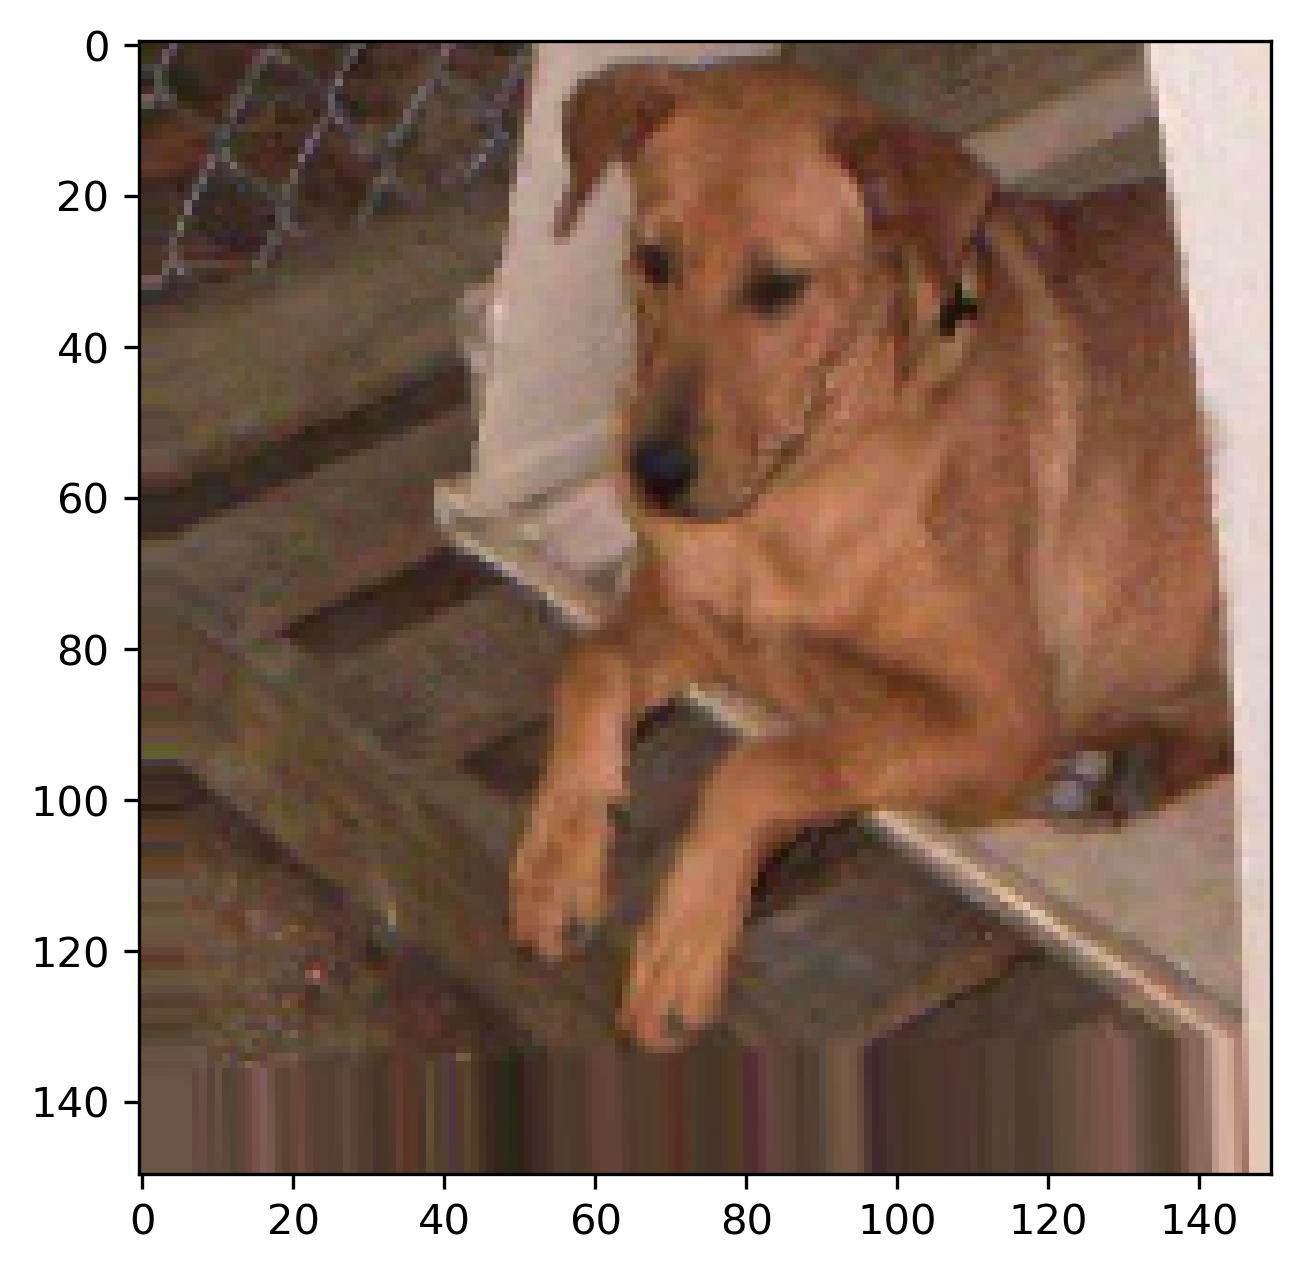

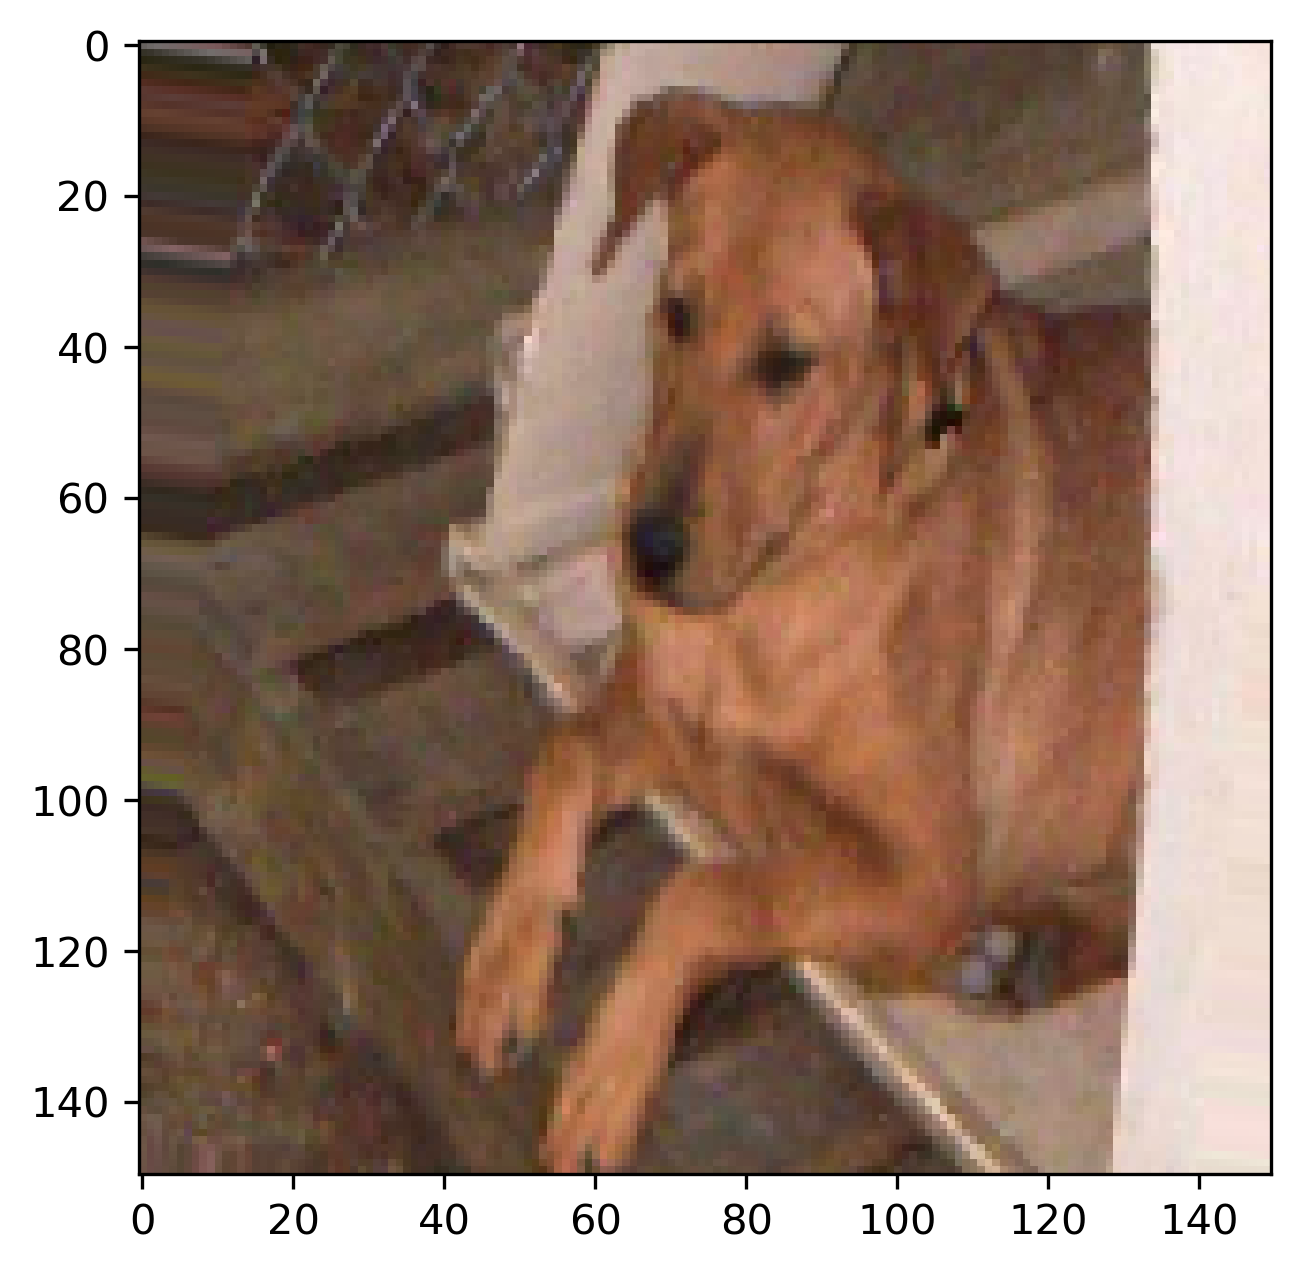

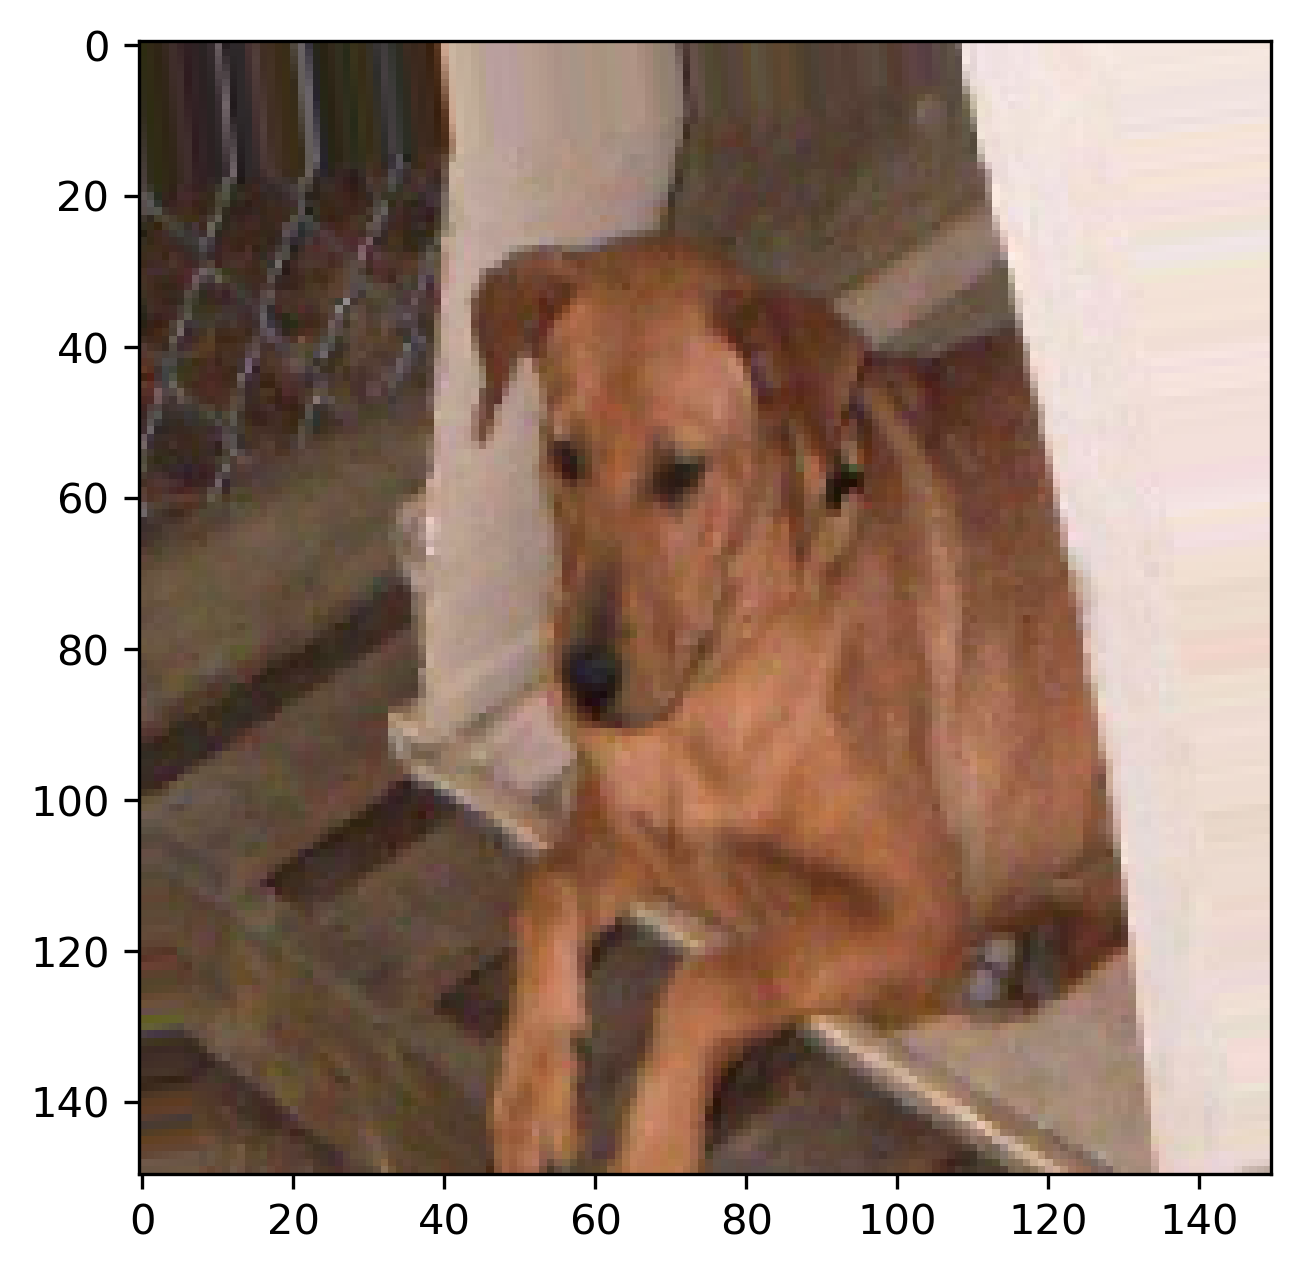

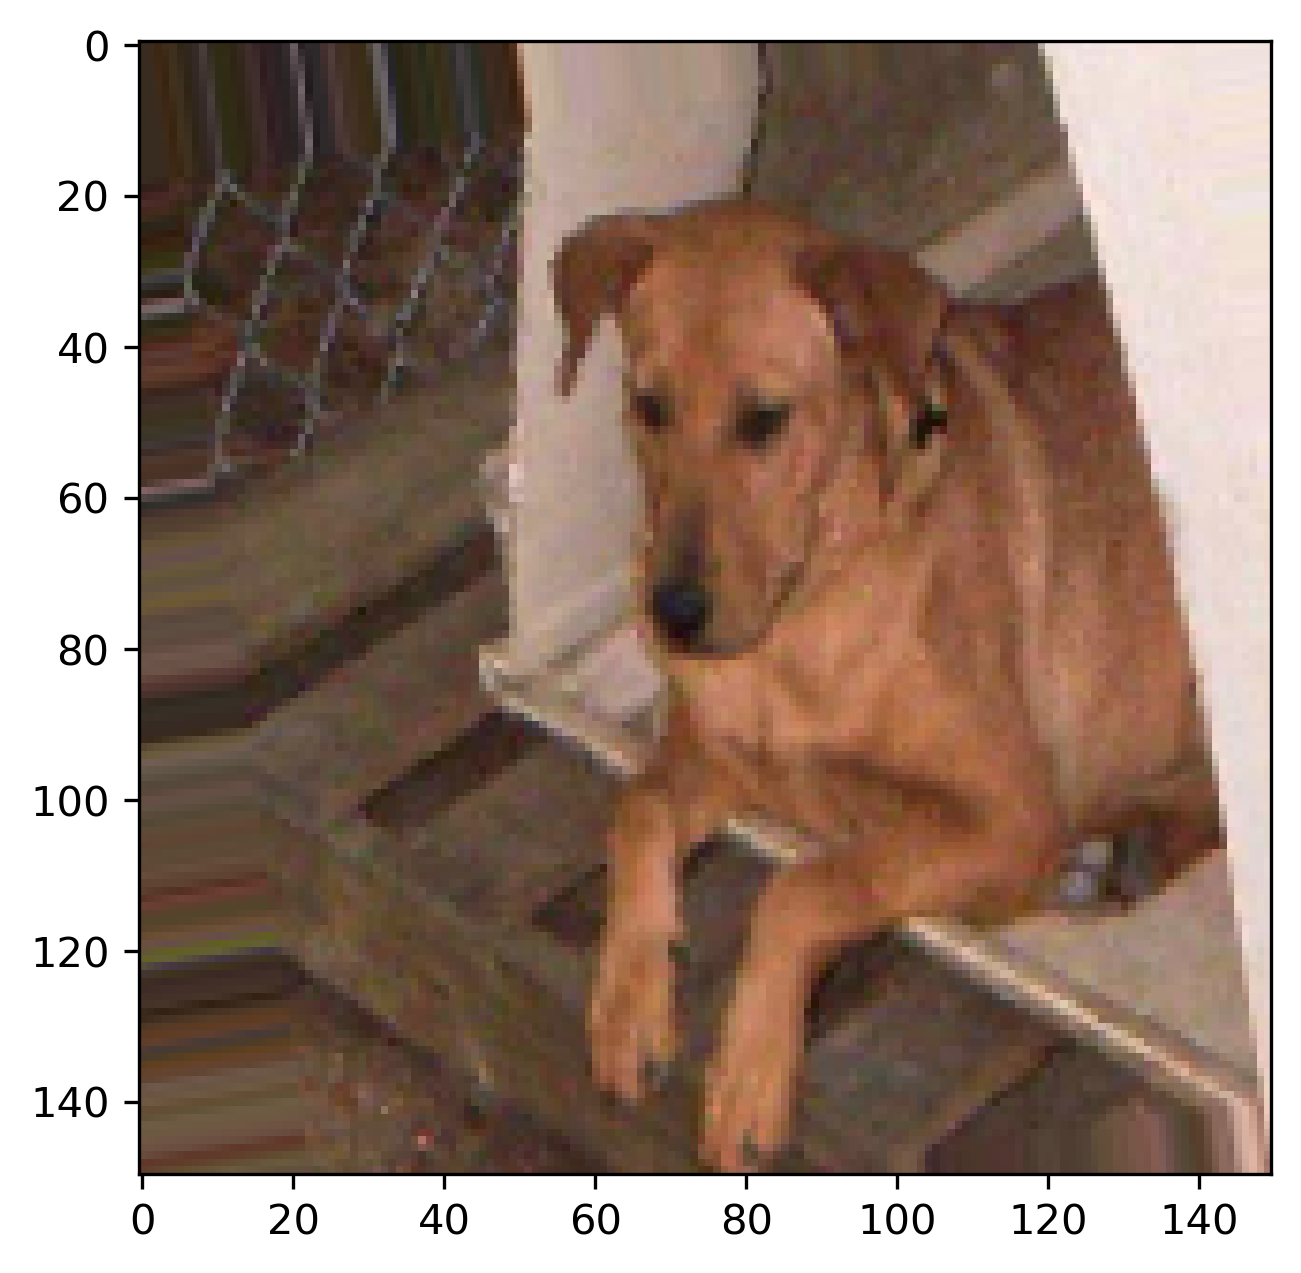

In [40]:
fnames = sorted([os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)])
img_path = fnames[3]
img = image.load_img(img_path, target_size=(150, 150))
x=image.img_to_array(img)
x = x.reshape((1,)+x.shape)

i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i%4 == 0:
        break
plt.show()
        

### Dropout을 포함한 새로운 컨브넷 정의하기

In [43]:
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss = 'binary_crossentropy',
             metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [44]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255) # 검증데이터는 증식되면안됨!

train_generator= train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

validation_generator= test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                             validation_steps=50)

model.save('dogs-vs-cats_small_2.h5')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 74s 736ms/step - loss: 0.6971 - acc: 0.5106 - val_loss: 0.6871 - val_acc: 0.5990
Epoch 2/100
100/100 [==============================] - 73s 734ms/step - loss: 0.6875 - acc: 0.5394 - val_loss: 0.6682 - val_acc: 0.5992
Epoch 3/100
100/100 [==============================] - 76s 756ms/step - loss: 0.6794 - acc: 0.5594 - val_loss: 0.6650 - val_acc: 0.5451
Epoch 4/100
100/100 [==============================] - 74s 742ms/step - loss: 0.6666 - acc: 0.5859 - val_loss: 0.6332 - val_acc: 0.6263
Epoch 5/100
100/100 [==============================] - 73s 730ms/step - loss: 0.6561 - acc: 0.6025 - val_loss: 0.6569 - val_acc: 0.5888
Epoch 6/100
100/100 [==============================] - 74s 740ms/step - loss: 0.6390 - acc: 0.6281 - val_loss: 0.6012 - val_acc: 0.6830
Epoch 7/100
100/100 [==============================] - 73s 728ms/step - loss: 0.6201 - acc: 0.6547 -

findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans.


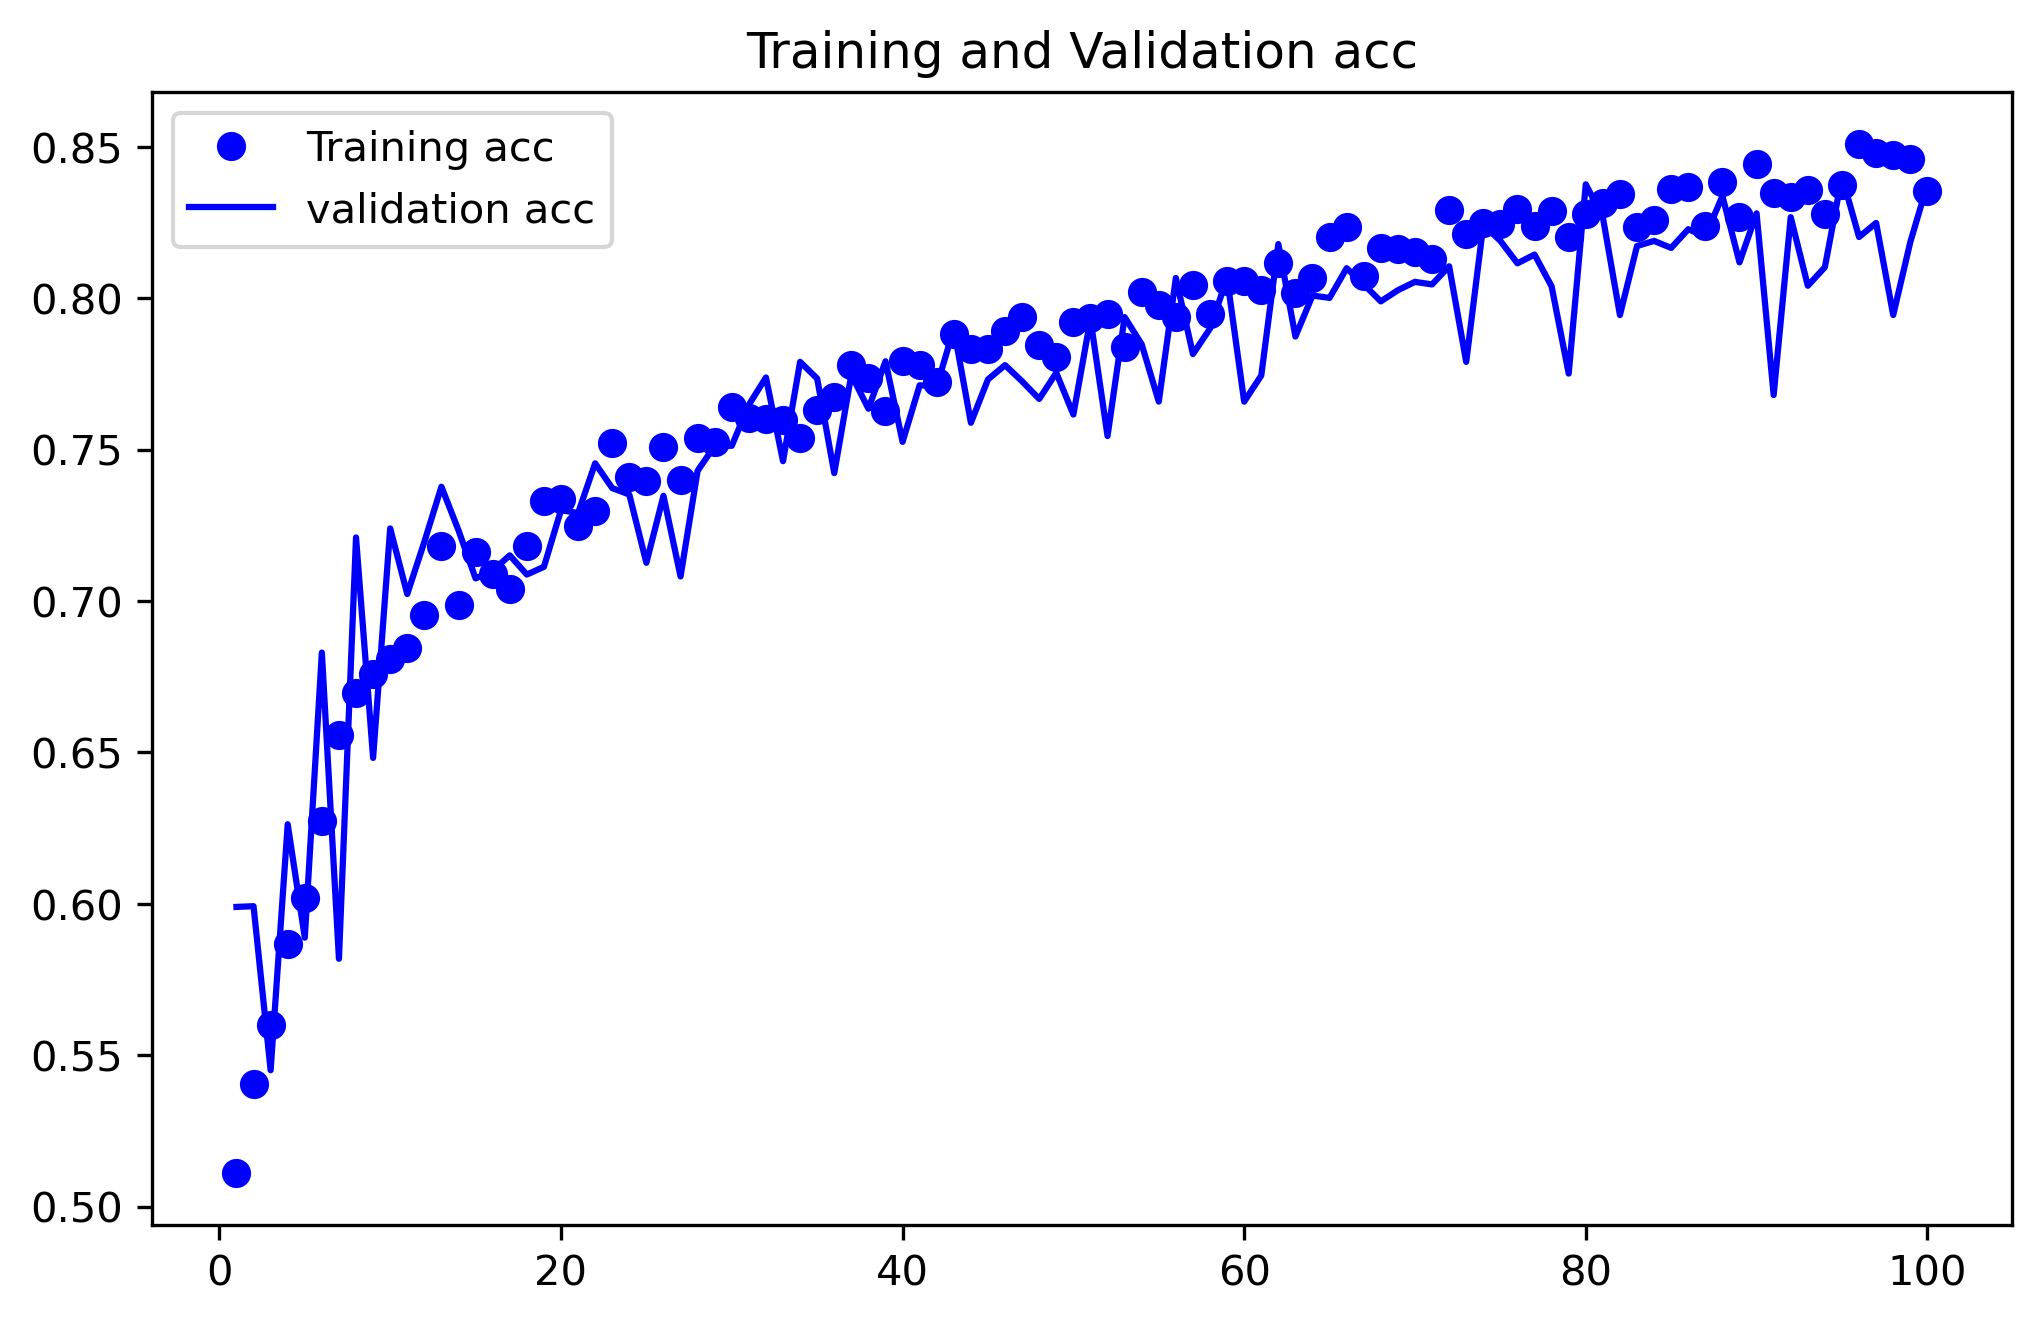

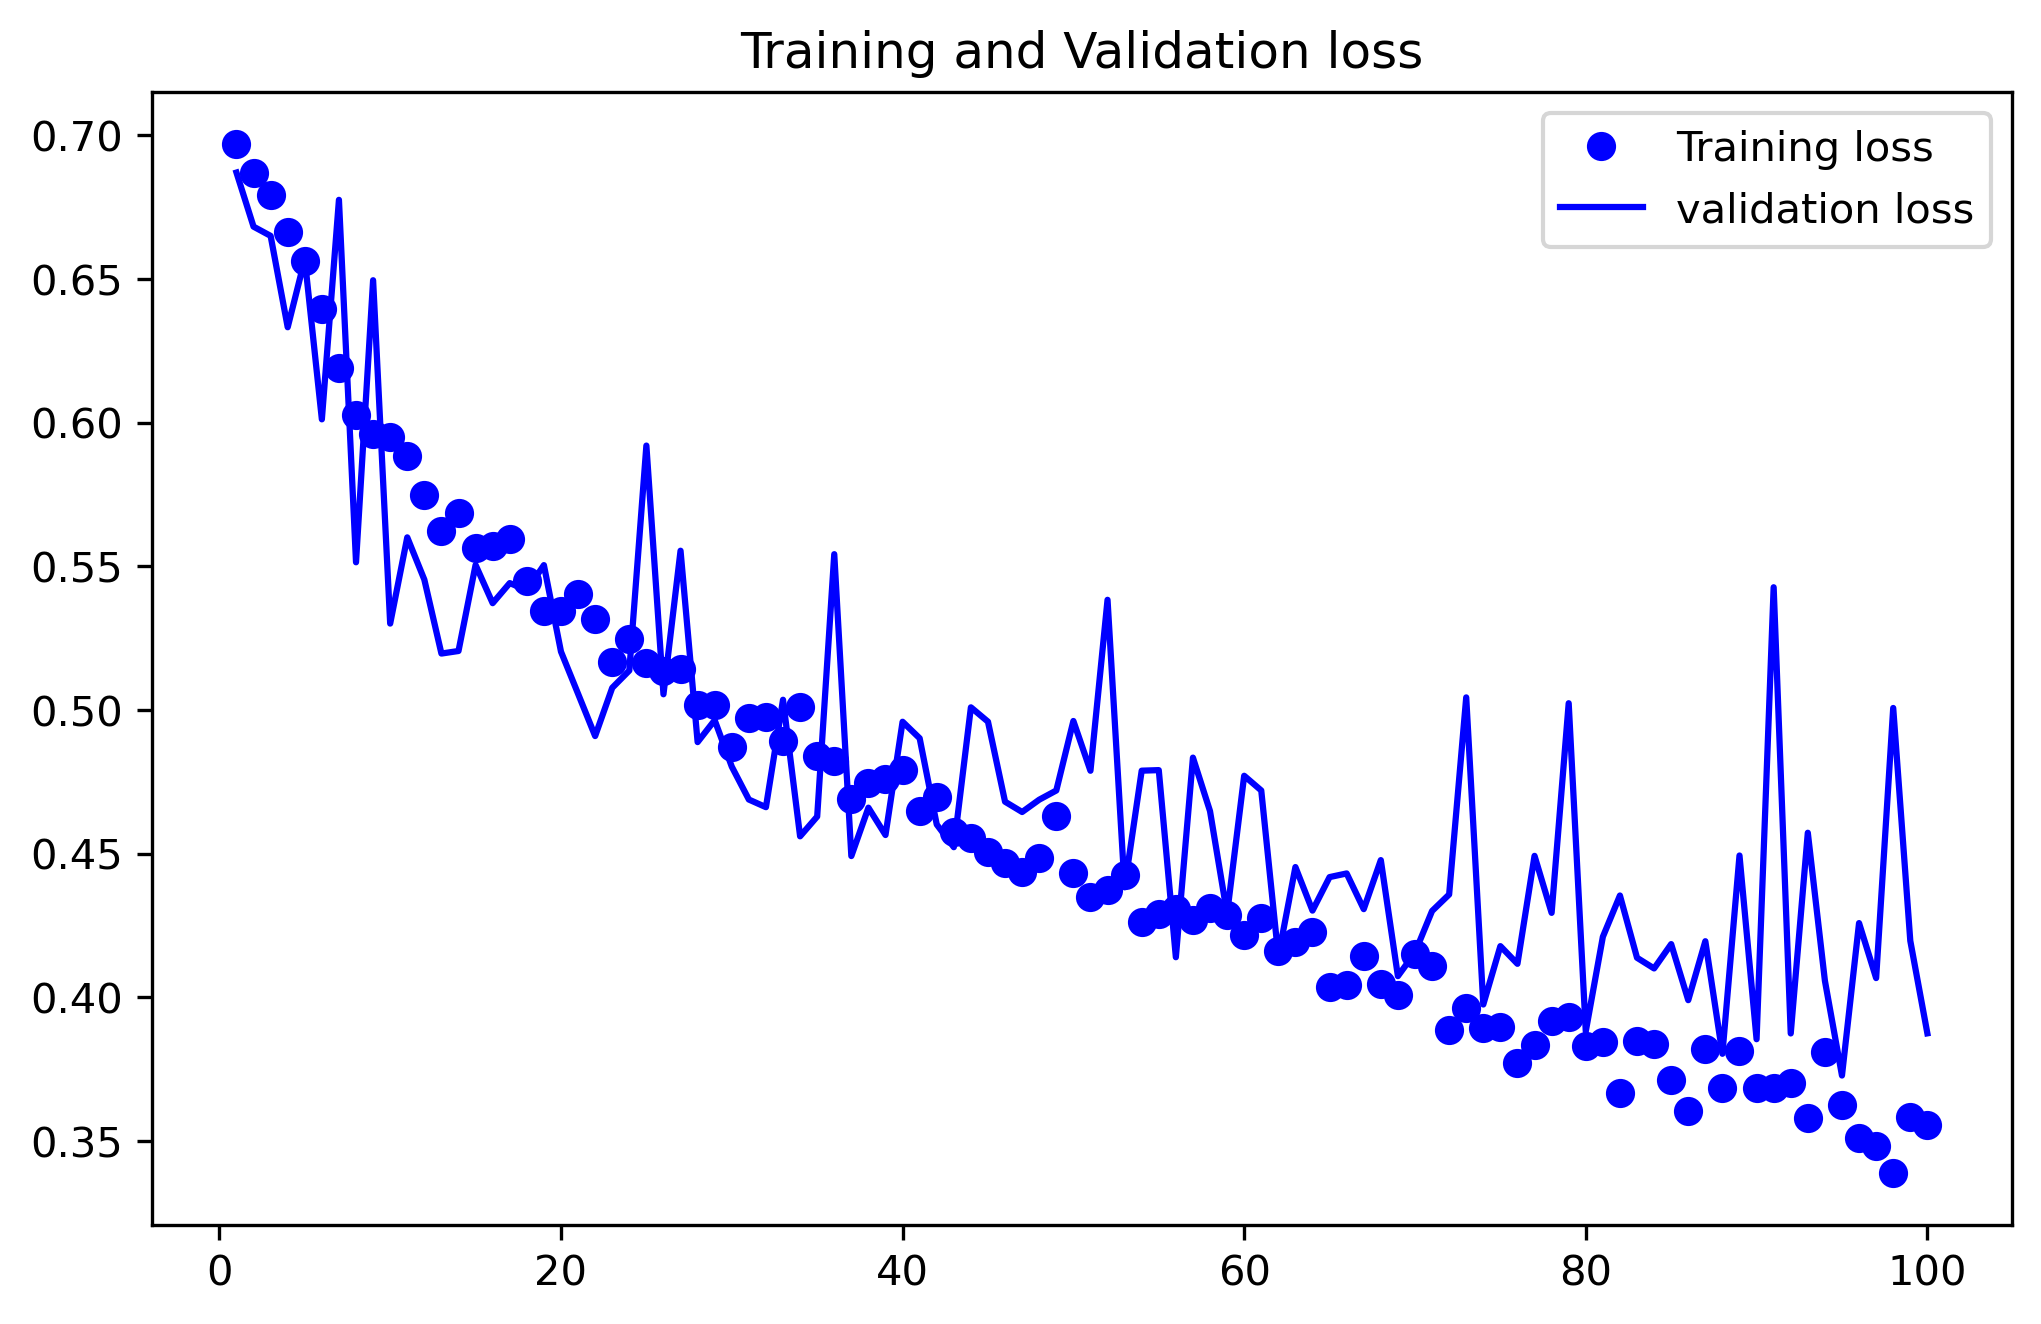

In [45]:
# 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()